## Отчет №3 Построение модели

**Цели этапа:**

Определить преимущества архитектуры EfficientNet_B0.

Построить модель, указав количество слоев и параметры модели.

**Архитектура:**

Архитектура EfficientNet_B0 представляет собой современный подход к обработке изображений, который оптимизирует баланс между точностью модели и ее вычислительной эффективностью. Ключевой особенностью является использование техники compound scaling, которая масштабирует глубину, ширину и разрешение сети для достижения наилучшей производительности.

**Компоненты архитектуры:**

Base Network: EfficientNet_B0 включает несколько мобильных сверточных блоков (Mobile Inverted Bottleneck), использующих механизмы свертки и внимания.

Слои Global Average Pooling: Они преобразуют пространственные признаки в компактные векторные представления.

Classification Head: Последние слои сети предназначены для классификации и построения предсказаний.

**Параметры модели:**

model_str: EfficientNet_B0 – предварительно обученная модель на ImageNet, адаптированная для текущей задачи.

num_labels: Определяется автоматически, в данном случае — 3 (Грусть, Радость, Гнев).

num_train_epochs: Количество эпох обучения.

learning_rate: Скорость обучения, подбирается экспериментально.

per_device_train_batch_size: Размер батча для обучения.

per_device_eval_batch_size: Размер батча для оценки.

Архитектура EfficientNet_B0 была выбрана за ее вычислительную эффективность и способность достигать высокой точности при минимальных ресурсах.

Построем две модели, чтобы доказать, что модель с EfficientNet_B0 эффективнее


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(5, 5, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(5, 5, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(5*56*56, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim =1)


In [ ]:
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = ConvNet()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
import torchmetrics
accuracy_metric = torchmetrics.Accuracy(task = 'multiclass', num_classes = 3).to(device)

Модель с EfficientNet_B0


In [ ]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

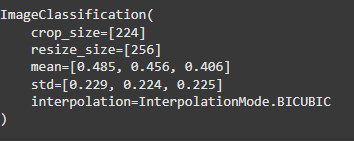

In [ ]:
train = CustomImageDataset(tr, transform = auto_transforms)
valid = CustomImageDataset(val, transform = auto_transforms)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid, batch_size=BATCH_SIZE)

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=3,
                    bias=True)).to(device)

In [ ]:
for param in model.features[8].parameters():
    param.requires_grad = True

In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

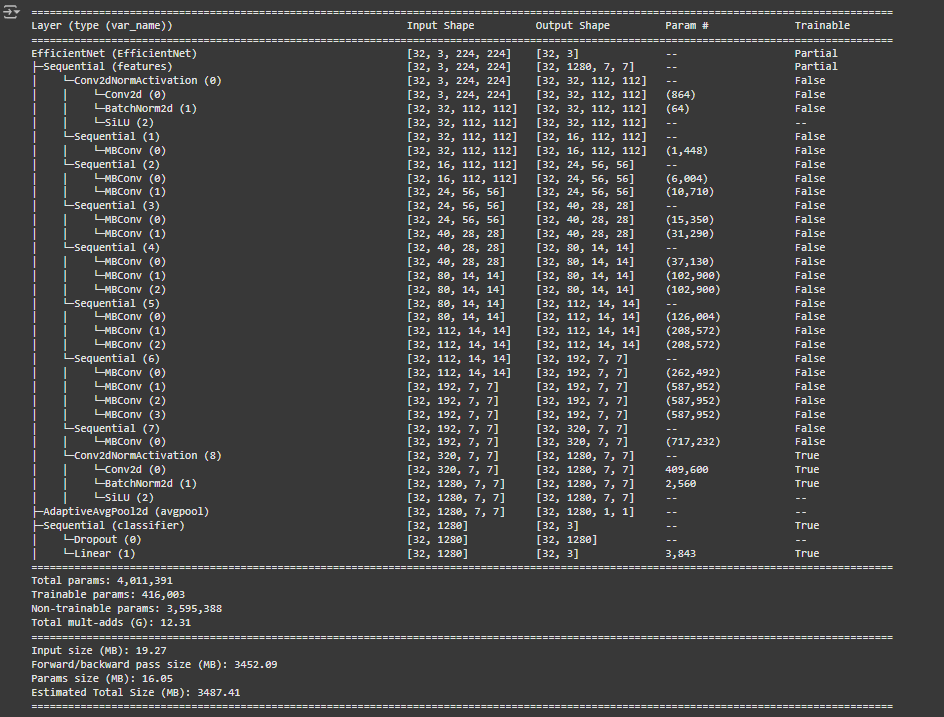

На следующем этапе докажем, что точность EfficientNet_B0 выше